# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [1]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [2]:
rules_data_path = 'data/rules.tsv.xz'                       # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                       },
                       low_memory=True)                     # For Chris

But just *how* many rules were just loaded‽

In [3]:
# Show the list of column names and the number of rules.
print(df_rules.columns)
print(len(df_rules))


Index(['consequent_item', 'transaction_count', 'item_set_count',
       'antecedent_count', 'consequent_count', 'antecedent_items'],
      dtype='object')
1048575


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [8]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

# Calculate support
df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']

# Calculate confidence
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']

# Calculate lift
df_rules['lift'] = (df_rules['item_set_count'] * df_rules['transaction_count']) / (df_rules['antecedent_count'] * df_rules['consequent_count'])

# Display the first 50 rules with added columns
df_rules.head(5)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

It's because the transaction count is absolutely insane compared to the rest of the metrics which is definitely messing things up

In [5]:
# Query the rule set if you have to to find out more.



## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [12]:
# Define df_rules_subset.

# Assuming df_rules is already defined and contains the necessary columns

df_rules['antecedent_count'] = df_rules['antecedent_items'].apply(lambda x: len(eval(str(x))) if isinstance(x, list) else 0)
df_single_antecedent = df_rules[df_rules['antecedent_count'] == 1]

# Step 2: Filter for lift between 5 and 20
df_lift_filtered = df_single_antecedent[(df_single_antecedent['lift'] >= 5) & (df_single_antecedent['lift'] <= 20)]

# Step 3: Filter for rules where either the antecedent or consequent contains 'Hummus', but not both
df_lift_filtered['antecedent_item'] = df_lift_filtered['antecedent_items'].apply(lambda x: str(eval(str(x))[0]) if isinstance(x, list) else '')
df_lift_filtered['contains_hummus'] = df_lift_filtered['antecedent_item'].str.contains('Hummus', case=False) | df_lift_filtered['consequent_item'].str.contains('Hummus', case=False)

df_rules_subset = df_lift_filtered[
    ((df_lift_filtered['contains_hummus']) & (df_lift_filtered['antecedent_item'].str.contains('Hummus', case=False) ^ df_lift_filtered['consequent_item'].str.contains('Hummus', case=False)))
]

# Clean the antecedent_item for visualization
df_rules_subset['antecedent_item'] = df_rules_subset['antecedent_item'].replace(to_replace=r'.*Hummus.*', value='Hummus', regex=True)

# Drop the 'contains_hummus' temporary column
df_rules_subset = df_rules_subset.drop(columns=['contains_hummus'])

# Display the resulting subset
df_rules_subset.info

C:\Users\dougl\AppData\Local\Temp\ipykernel_2972\3196542453.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lift_filtered['antecedent_item'] = df_lift_filtered['antecedent_items'].apply(lambda x: str(eval(str(x))[0]) if isinstance(x, list) else '')
C:\Users\dougl\AppData\Local\Temp\ipykernel_2972\3196542453.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lift_filtered['contains_hummus'] = df_lift_filtered['antecedent_item'].str.contains('Hummus', case=False) | df_lift_filtered['consequent_it

<bound method DataFrame.info of                                           consequent_item  transaction_count  \
377756  Total 2% Lowfat Greek Strained Yogurt With Blu...            3346083   
387837                                        Clementines            3346083   
416420                                    Original Hummus            3346083   
419119                                    Original Hummus            3346083   
422178                                    Original Hummus            3346083   
440198                                    Original Hummus            3346083   
442099                               Organic Baby Carrots            3346083   
463035                                    Original Hummus            3346083   
463988                                    Original Hummus            3346083   
476420                                    Original Hummus            3346083   
506520                                    Original Hummus            3346083   
519416  

Build a network `graph_rules_subset` from the association rules subset.

In [ ]:
df_rules_subset.info

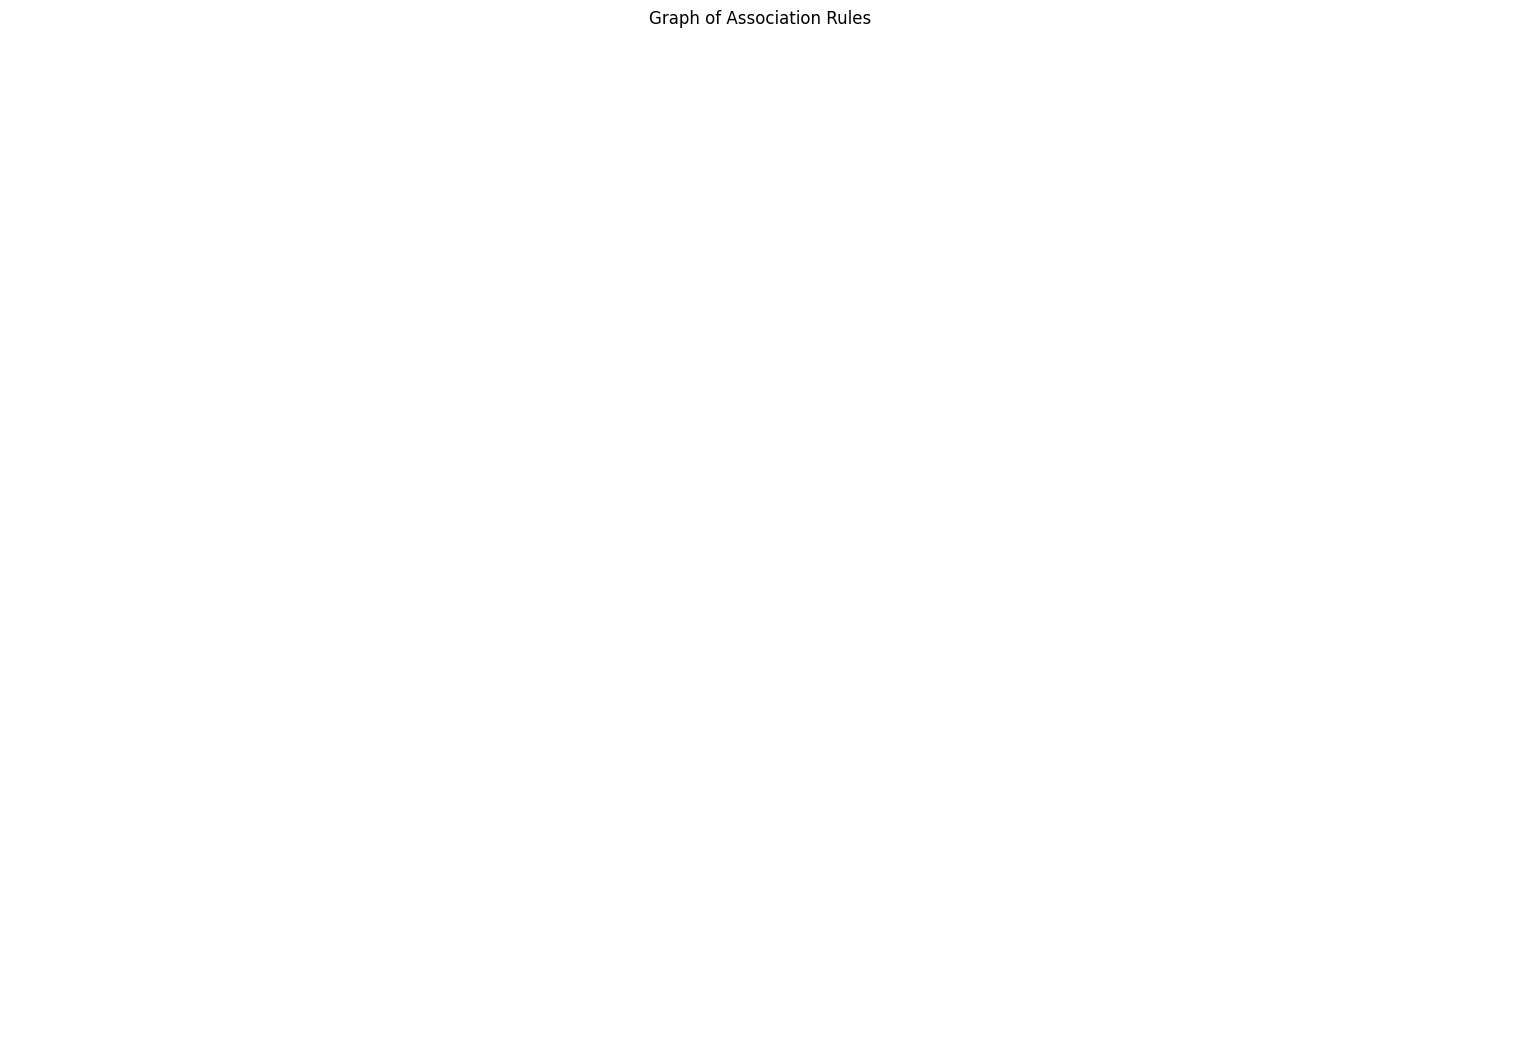

In [6]:
# Define the graph
graph_rules_subset = nx.MultiDiGraph()

# Add edges from the subset dataframe
graph_rules_subset.add_edges_from(
    df_rules_subset[['antecedent_items', 'consequent_item']].itertuples(index=False, name=None)
)

# Set up the figure size
plt.figure(figsize=(15, 10))  # Adjust size as needed

# Render the graph with specified parameters
nx.draw(
    graph_rules_subset,
    with_labels=True,
    node_size=50,  # Smaller node size
    font_size=8,   # Smaller font size
    arrows=True,
    arrowstyle='-|>',
    arrowsize=10
)

# Show the plot
plt.title("Graph of Association Rules")
plt.show()



What can you tell about people who buy hummus?

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [ ]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

df_rules[# A few conditions go here which takes care of all the following cases:
         # * Just Orange Bell Pepper
         # * Just Organic Red Bell Pepper
         # * Both Orange Bell Pepper and Organic Red Bell Pepper
         # You can do it using just 2 conditions. :)
         ] \
        .sort_values('lift', ascending=False) \
        .head(20)

## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.